# 1. Imports

In [1]:
import pandas as pd
import inflection
import numpy as np
import datetime


import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import HTML
from IPython.display import Image

import warnings
from scipy.stats import kurtosis

## 1.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 11

    display( HTML( '<style>.container { width:100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option( 'display.max_columns', None )

    sns.set_style("darkgrid")
    sns.set_palette("muted")

    warnings.filterwarnings('ignore')


In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 1.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

# check
df_raw.sample(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
101788,324,5,2015-05-01,0,0,0,1,a,0,a,a,13140.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
25978,334,3,2015-07-08,3865,426,1,0,0,1,d,c,4040.0,8.0,2008.0,1,18.0,2013.0,"Mar,Jun,Sept,Dec"


# 2. Data Description

In [5]:
# Dataset copy
df1 = df_raw.copy()

## 2.1. Renaming Columns

In [6]:
# check the column names
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = df1.columns
snake_case = lambda x: inflection.underscore(x)
cols_new = list( map(snake_case, cols_old) )

# rename columns
df1.columns = cols_new

## 2.2. Data Dimensions

In [8]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number os columns: {df1.shape[1]}')

Number of Rows: 1017209
Number os columns: 18


## 2.3. Data Types

In [9]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [10]:
# changing date to datetime type
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 2.4. Check NA

In [11]:
df1.isna().sum().sort_values(ascending = False)

promo_interval                  508031
promo2_since_year               508031
promo2_since_week               508031
competition_open_since_year     323348
competition_open_since_month    323348
competition_distance              2642
day_of_week                          0
promo2                               0
assortment                           0
store                                0
school_holiday                       0
state_holiday                        0
promo                                0
open                                 0
customers                            0
sales                                0
date                                 0
store_type                           0
dtype: int64

## 2.5. Fillout NA

* **competition_distance**  
    - Distance in meters to nearest competitor store.
    - If value is null, it means there are no near competitors.
    - Column filled with a value that is much higher than the maximum competition_distance in the dataset.

In [12]:
df1['competition_distance'].max()

75860.0

In [13]:
df1['competition_distance'].fillna(200000, inplace = True)

* **competition_open_since_year** and **competition_open_since_month**
    - Approximately the year and month the nearest competitor was opened.
    - Column filled with the year and month from the "date" column.

In [14]:
df1['competition_open_since_year'].fillna( df1['date'].dt.year, inplace = True)
df1['competition_open_since_month'].fillna( df1['date'].dt.month, inplace = True)

* **promo2_since_year** and **promo2_since_week**
    - Year and calendar week when the store started participating in promo2.
    - Column filled with the year and corresponding calendar week from the "date" column.

In [15]:
df1['promo2_since_year'].fillna(df1['date'].dt.year, inplace = True)
df1['promo2_since_week'].fillna(df1['date'].dt.isocalendar().week, inplace = True)

* **promo_interval**
    - Consecutive intervals Promo2 is started, naming the months the promotion started.
    - Column filled with zeros.
    - New column "is_promo" created to indicates if there was a promo in the store that date. (1: Store was in promo / 0: Store was not in promo)

In [16]:
df1['promo_interval'].fillna(0, inplace = True)

# month map to help the operation
month_map = {1 : 'Jan', 2 : 'Fev', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sept', 
 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}

df1['month_map'] = df1['date'].dt.month.map( month_map )
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else (1 if x['month_map'] in x['promo_interval'].split( "," ) else 0), axis = 1)

In [17]:
# check for NA values again
df1.isna().sum().sort_values(ascending = False)

store                           0
day_of_week                     0
month_map                       0
promo_interval                  0
promo2_since_year               0
promo2_since_week               0
promo2                          0
competition_open_since_year     0
competition_open_since_month    0
competition_distance            0
assortment                      0
store_type                      0
school_holiday                  0
state_holiday                   0
promo                           0
open                            0
customers                       0
sales                           0
date                            0
is_promo                        0
dtype: int64

## 2.6. Change Data Types

In [18]:
# competition data to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

# promo data to int
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 2.7. Descriptive Statistics

The metrics are divided by attribute types: Numerical and Categorical

In [19]:
# dataset with only numerical attributes
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])

# dataset with only categorical attributes
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 2.7.1. Numerical Attributes

Some of the metrics to look at are as follows:

* **Central tendency**
    - mean
    - median
* **Dispersion**
    - minimum (min)
    - maximum (max)
    - range
    - standard deviation (std)
    - skew
    - kurtosis

In [20]:
# Central Tendency
_mean = pd.DataFrame(num_attributes.apply(np.mean)).T
_median = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion
_min = pd.DataFrame(num_attributes.apply(min)).T
_max = pd.DataFrame(num_attributes.apply(max)).T
_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
_std = pd.DataFrame(num_attributes.apply(np.std)).T
_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
summary = pd.concat([_min, _max, _range, _mean, _median, _std, _skew, _kurtosis]).T.reset_index()
summary.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
summary

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.161100,0.0,0.367623,1.843742,1.399388


* **Sales Analysis** 
    - The **"min = 0"** indicates there were days with no sales (store was closed).
    - The **"max = 41551"** indicates there were a maximum of 41551 sales per day.
    - The **"mean = 5773"** indicates there were on average 5773 sales per day.
    - The **"median = 5774"** is close to the mean, it indicates there aren't a lof of skewed data.
    - The **"std = 3849** indicates that for most days the number of sales is in the range 5773 +/\- 3849.
    - The **"skew = 0.641460**" indicates a slightly deslocation of the sales distribution to the left.
    - The **"kurtosis = 1.778375**" indicates the distribution has a slightly higher peak than a normal distribution.

* **Sales Plot** 

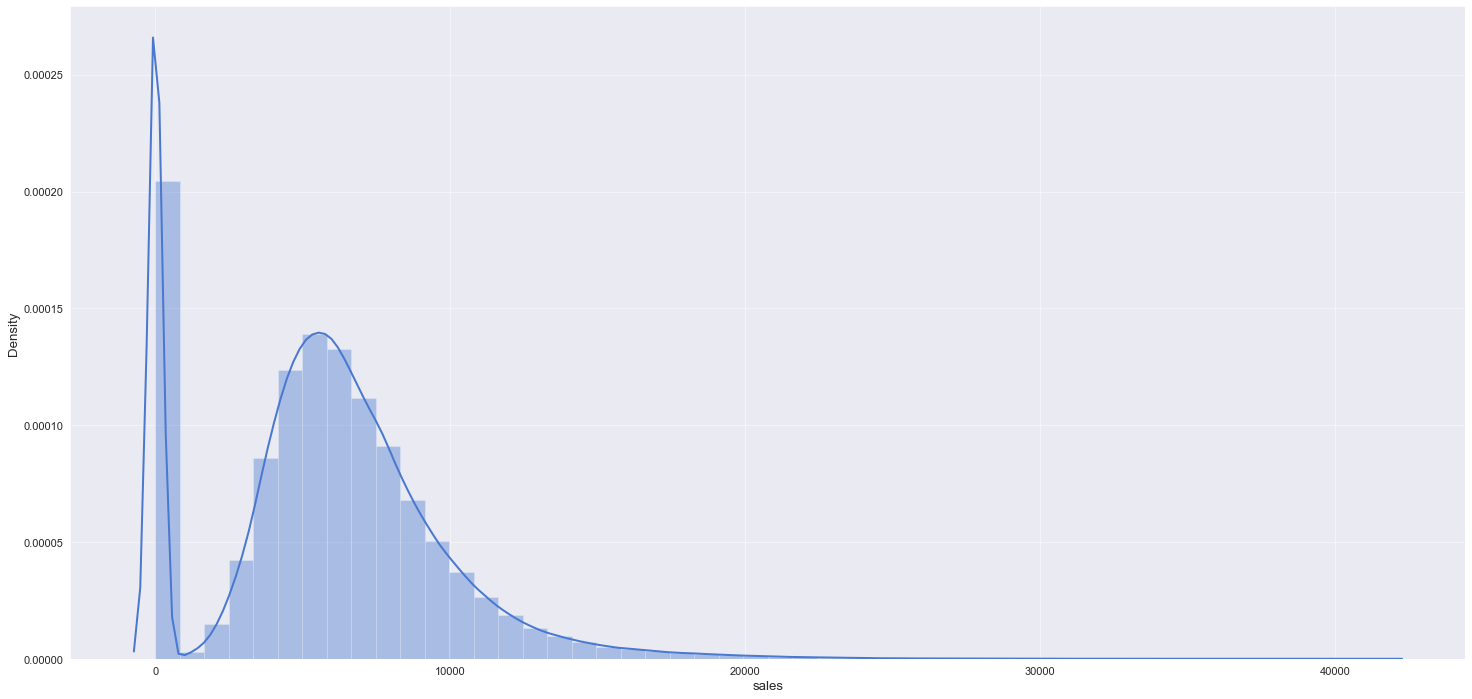

In [21]:
# plots distribution
sns.distplot(df1['sales'])
plt.show()

### 2.7.2. Categorical Attributes

We can get the number of sales for each unique values of these features.

In [22]:
# Qtd. of unique attributes per feature
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

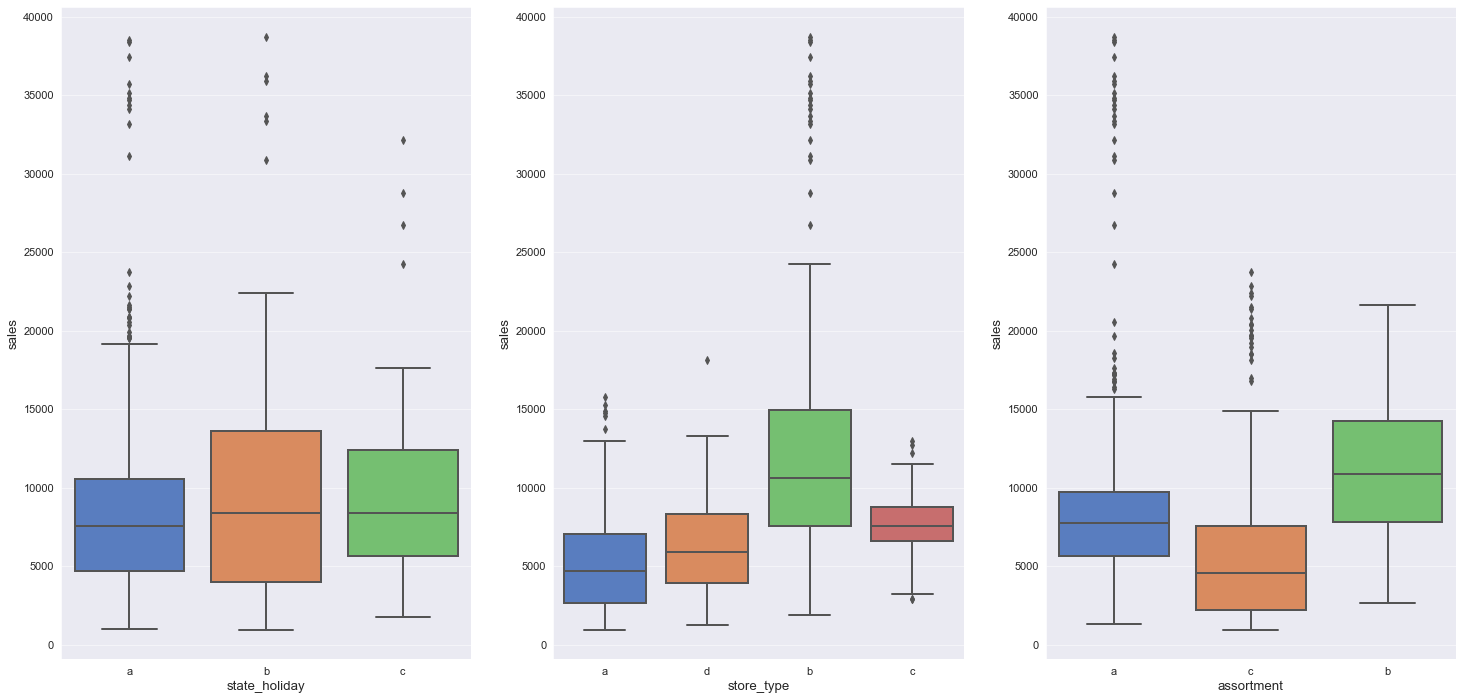

In [23]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

fig, axes = plt.subplots(1, 3)

_ = sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1, ax = axes[0])
_ = sns.boxplot(x = 'store_type', y = 'sales', data = aux1, ax = axes[1])
_ = sns.boxplot(x = 'assortment', y = 'sales', data = aux1, ax = axes[2])

plt.show()

# 3. Featuring Engineering

We have to understand the phenomenon that is being modeled and it's agents.

* **Phenomenon:** Sales
* **Agents:** Clients
    - Described by: Age, Sex, Job, ... 

## 3.1. Mind Map

![mindmap.png](img/MindmapHyphotesis.png)

## 3.2. Creating Hypothesis

Creating hypothesis for the variables that could have some influence in the phenomenon. 

### 3.2.1 Store's Hypothesis 

**1.**  Stores with more employees should sell more.

**2.**  Stores with more stock should should sell more.

**3.** Bigger stores should sell more.

**4.** Stores with more assortment should sell more.

**5.** Stores with nearer competitors should sell less.

**6.** Stores with longer competitors should sell more.

### 3.2.2. Product's Hypothesis

**1.** Stores with more investment in marketing should sell more.

**2.** Stores with more products exposed should sell more.

**3.** Stores with lower prices should sell more.

**4.** Stores with bigger promotions should sell more.

**5.** Stores with lower prices for longer periods should sell more.

**6.** Stores with more promotion days should sell more.

**7.** Stores with more consecutive promotions should sell more.

### 3.2.3. Time's Hypothesis

**1.** Stores opened during Christmas should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second semester of the year.

**4.** Stores should sell more after the 10th day of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 3.3. Main Hypothesis List

These hypotheses were chosed based on the available data.

**1.** Stores with more assortment should sell more.

**2.** Stores with nearer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with lower prices for longer periods should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores opened during Christmas should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second semester of the year.

**10.** Stores should sell more after the 10th day of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## 3.4. Creating New Features

New features are created to help with the Exploratory Data Analysis (EDA).

In [24]:
# Dataset copy
df2 = df1.copy()

* **Calendar**

In [25]:
# year
df2['year'] = df2['date'].dt.year

# month 
df2['month'] = df2['date'].dt.month

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# check
df2[['date', 'year', 'month', 'week_of_year', 'year_week']].sample(2)

,date,year,month,week_of_year,year_week
74109,2015-05-26,2015,5,22,2015-21
638293,2013-12-06,2013,12,49,2013-48


* **Competition**

In [26]:
# competition since
df2['competition_since'] = df2.apply(lambda x: 
    datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)

# competition time month
df2['competition_time_month'] = ( (df2['date'] - df2['competition_since']) / 30 ).apply( lambda x: x.days ).astype( int )

# check
df2[['date', 'competition_open_since_year', 'competition_open_since_month', 'competition_since', 'competition_time_month']].sample(2)

,date,competition_open_since_year,competition_open_since_month,competition_since,competition_time_month
324544,2014-09-28,2006,3,2006-03-01,104
881628,2013-05-02,2014,12,2014-12-01,-20


* **Promo**

In [27]:
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))

# promo time week
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# check 
df2[['date', 'promo2_since_year', 'promo2_since_week', 'promo_since', 'promo_time_week']].sample(2)

,date,promo2_since_year,promo2_since_week,promo_since,promo_time_week
963252,2013-02-18,2011,40,2011-09-26,73
28874,2015-07-06,2014,40,2014-09-29,40


* **Assortment**

In [28]:
assortment = {'a' : 'basic', 'b' : 'extra', 'c' : 'extended'}

# assortment
df2['assortment'] = df2['assortment'].map(assortment)

* **Holyday**

In [29]:
state_holiday = {'a' : 'public_holiday', 'b' : 'easter_holiday', 'c' : 'christmas', '0' : 'regular_day'}

# state holiday
df2['state_holiday'] = df2['state_holiday'].map(state_holiday)

# 4. Data Filtering

Filtering the data is associetad to business restrictions.

In [30]:
# Dataset copy
df3 = df2.copy()

## 4.1. Rows Filtering

Rows indicating closed stores and stores with zero salles doesn't provide relevant information. They have to be removed.  

In [31]:
df3 = df3[ (df3["open"] != 0) & (df3["sales"] > 0) ]

## 4.2. Columns Selection

The columns to be removed are as follows:

* **customers:** This information would have to be predicted as well, so it is not available at the prediction time.

* **open:** It only has one's due to the rows filter.

* **promo_interval** and **month_map:** Their information were replaced by "is_promo" column.

In [32]:
df3.drop( columns = ['customers', 'open', 'promo_interval', 'month_map'], axis = 1, inplace = True )

#check
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 5. Exploratory Data Analysis (EDA)

The main 3 goals with EDA are as follows:

**1.** Gain business experience.

**2.** Validate the business hypothesis. (Insights)

**3.** Realize wich features are important to the model.

In [33]:
df4 = df3.copy()

## 5.1. Univariate Analysis

* **For example:** 'min', 'max', 'std' and 'range'.

### 5.1.1 Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

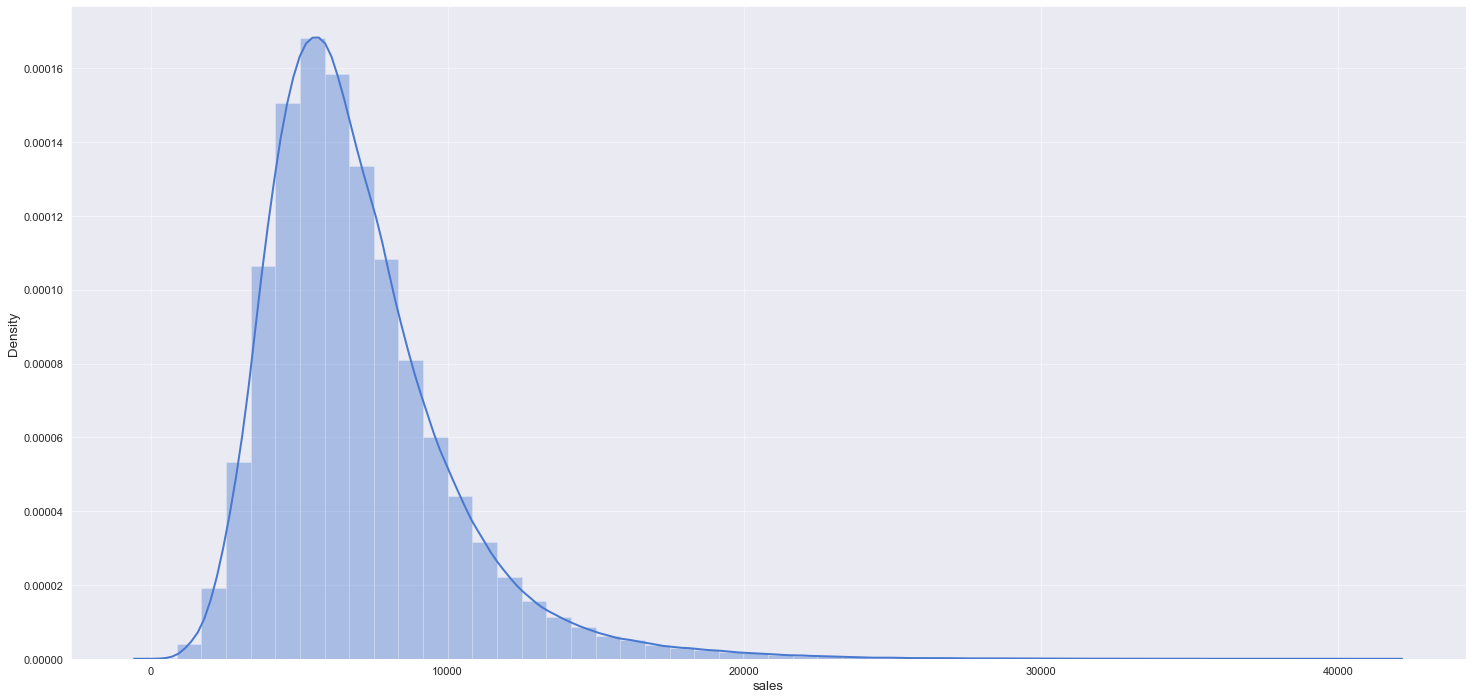

In [34]:
sns.distplot(df4['sales'])

Most machine learning algorithms perform better with normal distributions. So it's imporant to analyze the distribution to get some metrics like skew and kurtosis.

### 5.1.2 Numerical Variable

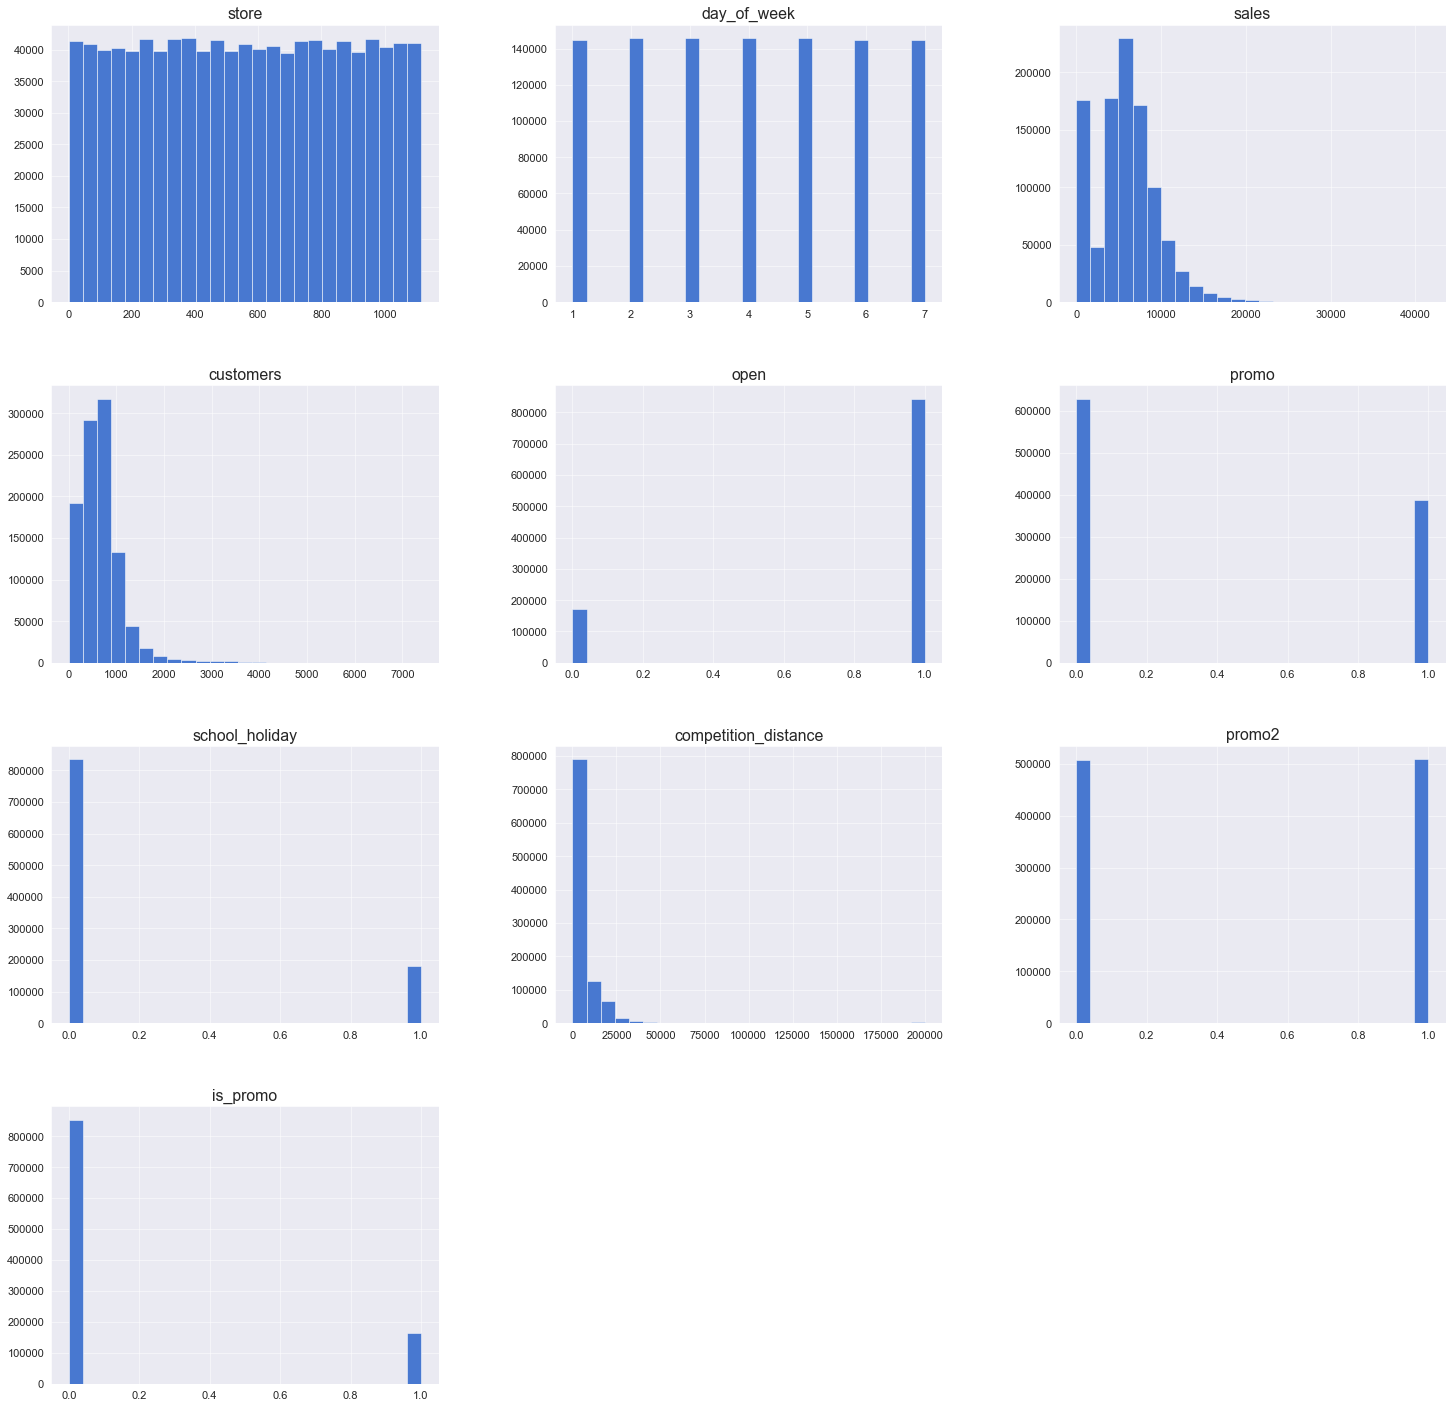

In [35]:
num_attributes.hist(bins = 25, figsize = (25, 25));

### 5.1.3. Categorical Variable

In [36]:
df4.select_dtypes(include = 'object').columns

Index(['state_holiday', 'store_type', 'assortment', 'year_week'], dtype='object')

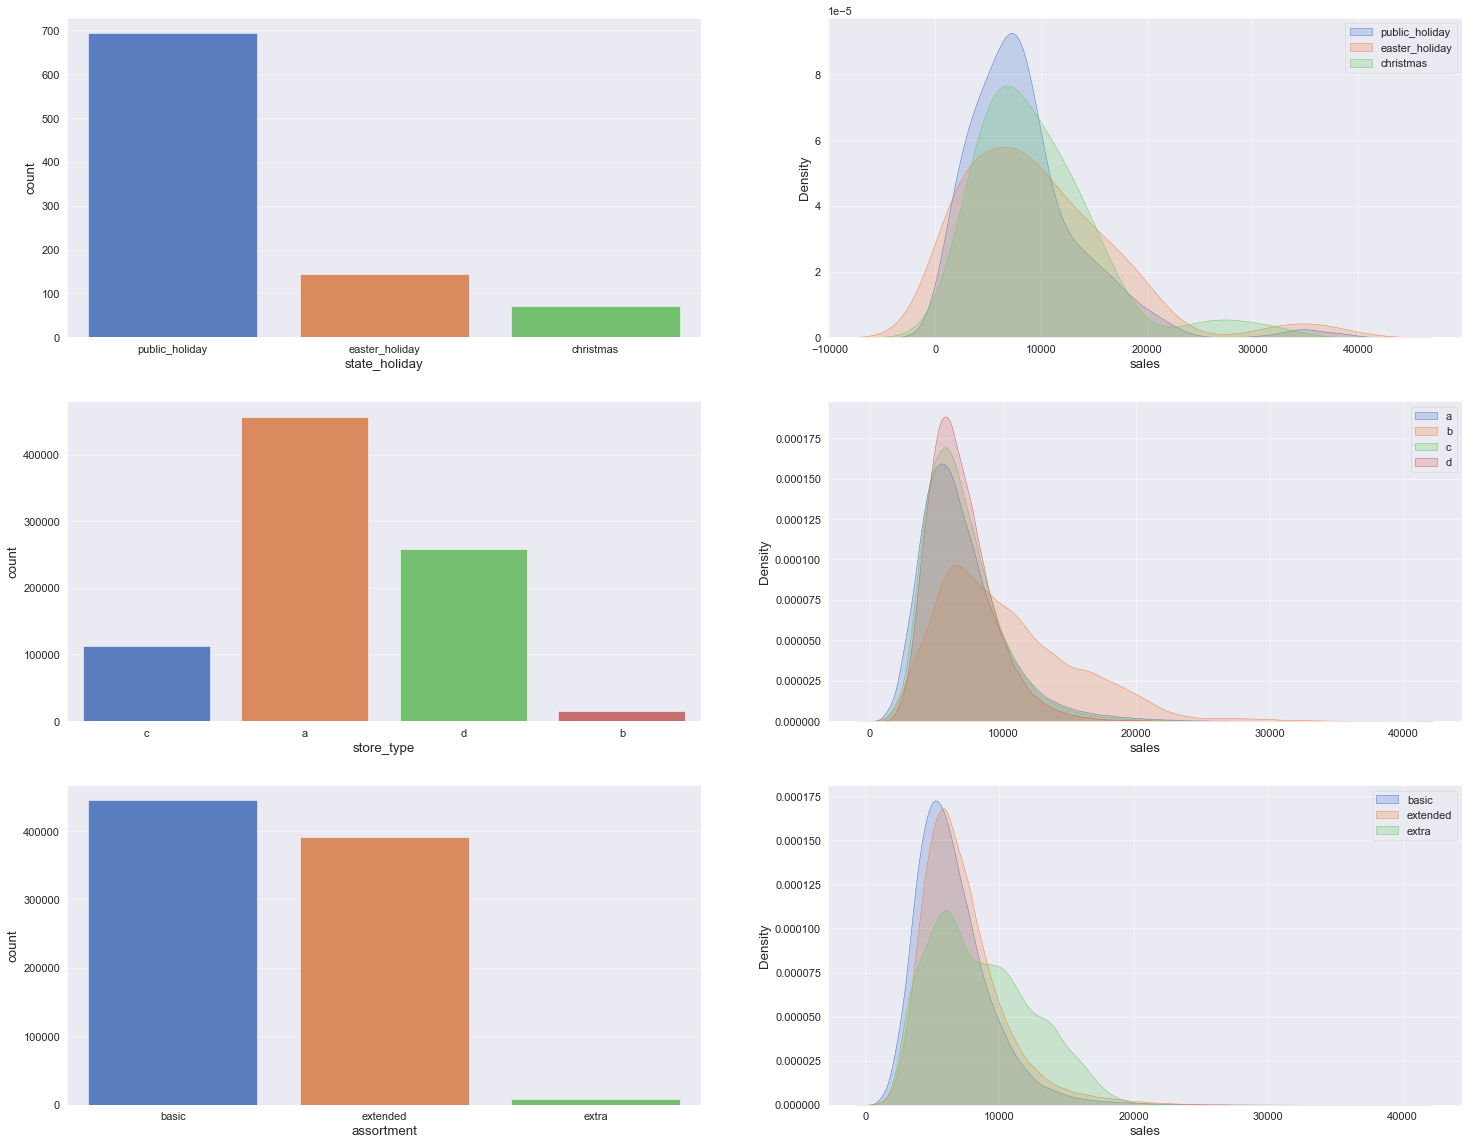

In [37]:
fig, axes = plt.subplots(3, 2, figsize  = (25,20))

#state_holiday
df_st = df4[df4['state_holiday'] != 'regular_day']

sns.countplot(x = df_st['state_holiday'], ax = axes[0][0])

sns.kdeplot(x = df4[df4['state_holiday'] == 'public_holiday']['sales'],label = 'public_holiday',shade = True, ax = axes[0][1])
sns.kdeplot(x = df4[df4['state_holiday'] == 'easter_holiday']['sales'],label = 'easter_holiday',shade = True, ax = axes[0][1])
sns.kdeplot(x = df4[df4['state_holiday'] == 'christmas']['sales'],label = 'christmas',shade = True, ax = axes[0][1])

#store_type
sns.countplot(x = df4['store_type'], ax = axes[1][0])

sns.kdeplot(x = df4[df4['store_type'] == 'a']['sales'],label = 'a',shade = True, ax = axes[1][1])
sns.kdeplot(x = df4[df4['store_type'] == 'b']['sales'],label = 'b',shade = True, ax = axes[1][1])
sns.kdeplot(x = df4[df4['store_type'] == 'c']['sales'],label = 'c',shade = True, ax = axes[1][1])
sns.kdeplot(x = df4[df4['store_type'] == 'd']['sales'],label = 'd',shade = True, ax = axes[1][1])

#assortment
sns.countplot(x = df4['assortment'], ax = axes[2][0])

sns.kdeplot(x = df4[df4['assortment'] == 'basic']['sales'], label  = 'basic', shade = True, ax = axes[2][1])
sns.kdeplot(x = df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True, ax = axes[2][1])
sns.kdeplot(x = df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True, ax = axes[2][1])

# legends and plot
axes[0][1].legend()
axes[1][1].legend()
axes[2][1].legend()
plt.show()

## 5.2. Bivariate Analysis

**1.** Stores with more assortment should sell more.

**2.** Stores with nearer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with lower prices for longer periods should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores opened during Christmas should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second semester of the year.

**10.** Stores should sell more after the 10th day of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

### H1. Stores with more assortment should sell more.

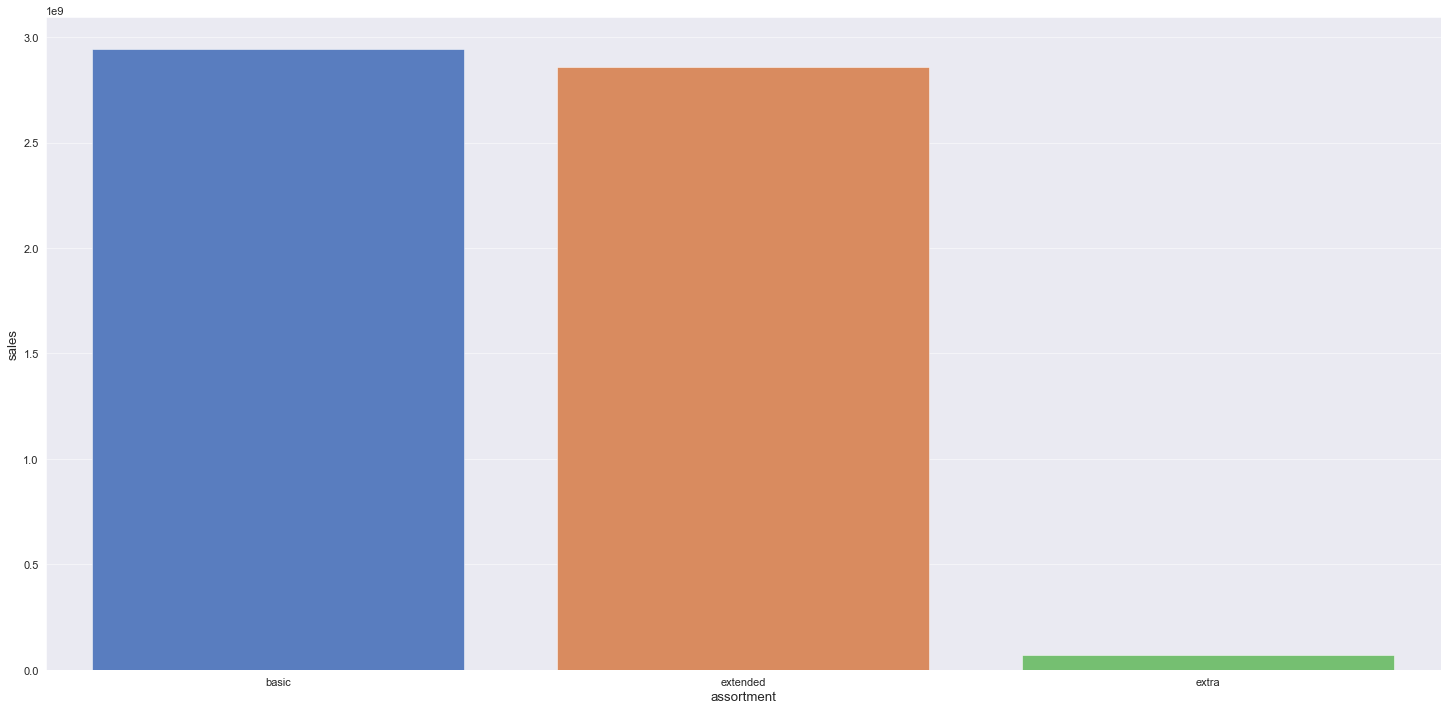

In [38]:
# plot sales for each assortment
df_aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x = 'assortment', y = 'sales', data = df_aux1 );

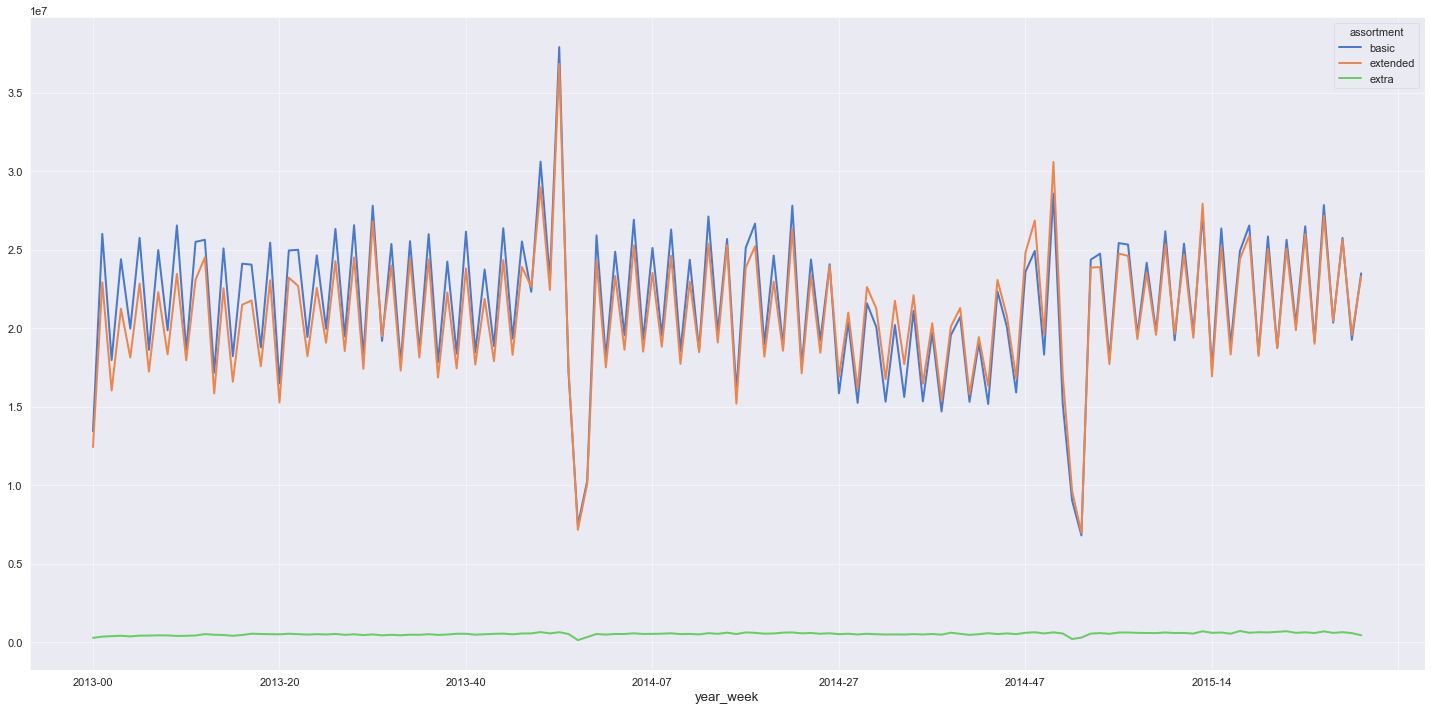

In [ ]:
# plot sales for each assortment per week_year 
df_aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
df_aux2.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot();

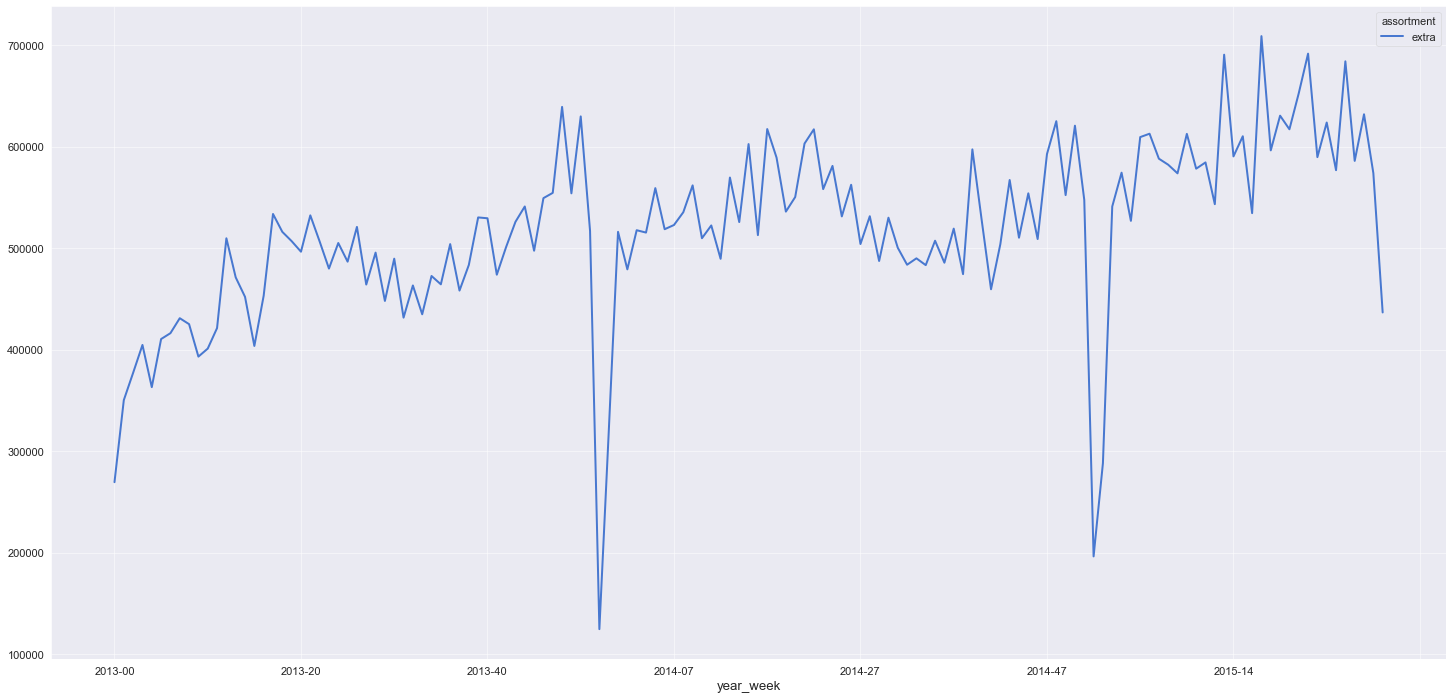

In [40]:
# plot sales for extra assortment per week_year 
df_aux3 = df_aux2[ df_aux2['assortment'] == 'extra' ]
df_aux3.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot();

* **FALSE** - Stores with less assortment should sell **less**.

### H2. Stores with nearer competitors should sell less.

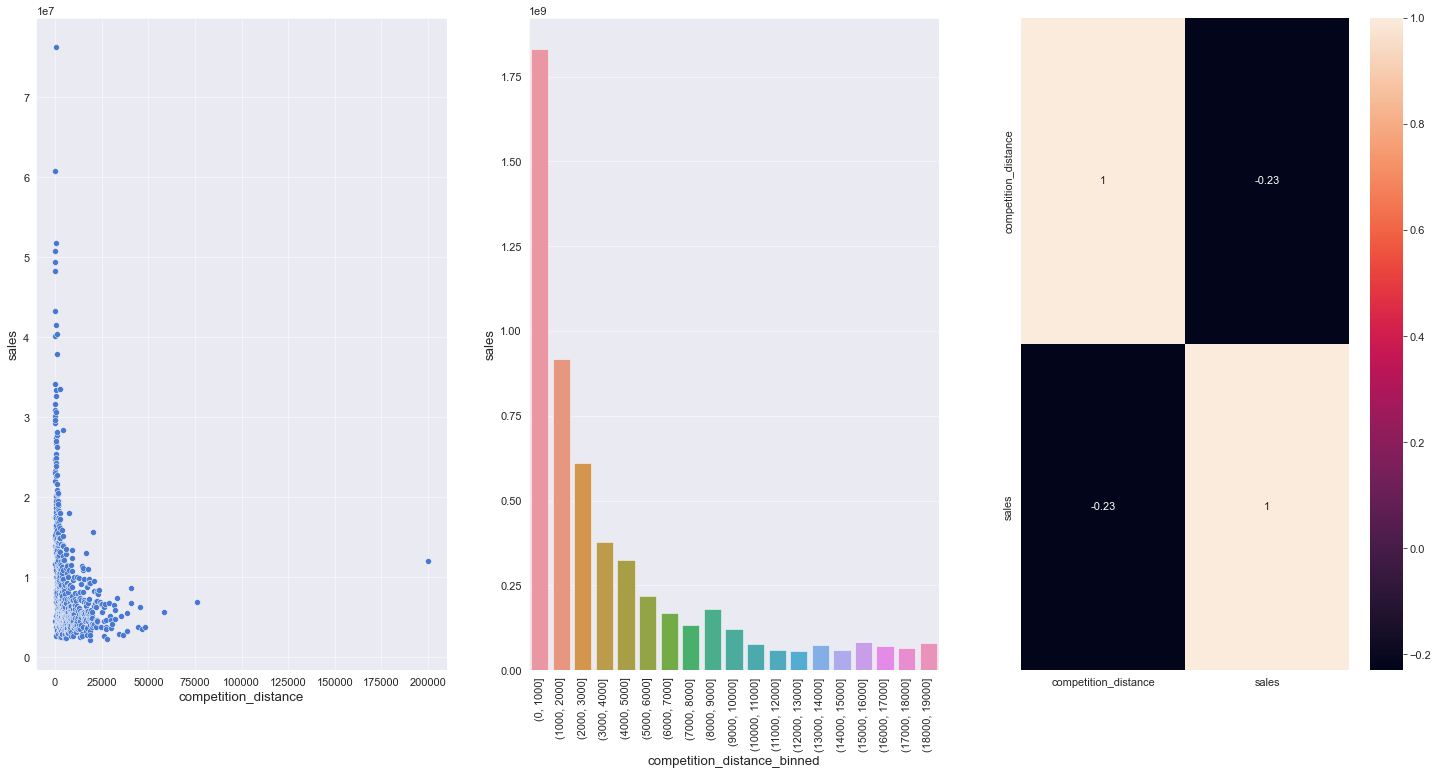

In [43]:
df_aux1 = df4[['competition_distance', 'sales']].groupby( ['competition_distance'] ).sum().reset_index()

# scatter plot of sales per competition distance
plt.subplot(1,3,1)
sns.scatterplot( x = 'competition_distance', y = 'sales', data = df_aux1 )

# bar plot of sales per ranges of competition distance
plt.subplot(1,3,2)
bins = list( np.arange(0, 20000, 1000) )
df_aux1['competition_distance_binned'] = pd.cut( df_aux1['competition_distance'], bins = bins )
df_aux2 = df_aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()

sns.barplot( x = 'competition_distance_binned', y = 'sales', data = df_aux2 )
plt.xticks(rotation = 90)

# strength of the correlation between sales and competition_distance
plt.subplot(1,3,3)
sns.heatmap( df_aux1.corr( method = 'pearson' ), annot = True );


* **FALSE** - Stores with nearer competitors should sell **more**.

### H3. Stores with longer competitors should sell more.

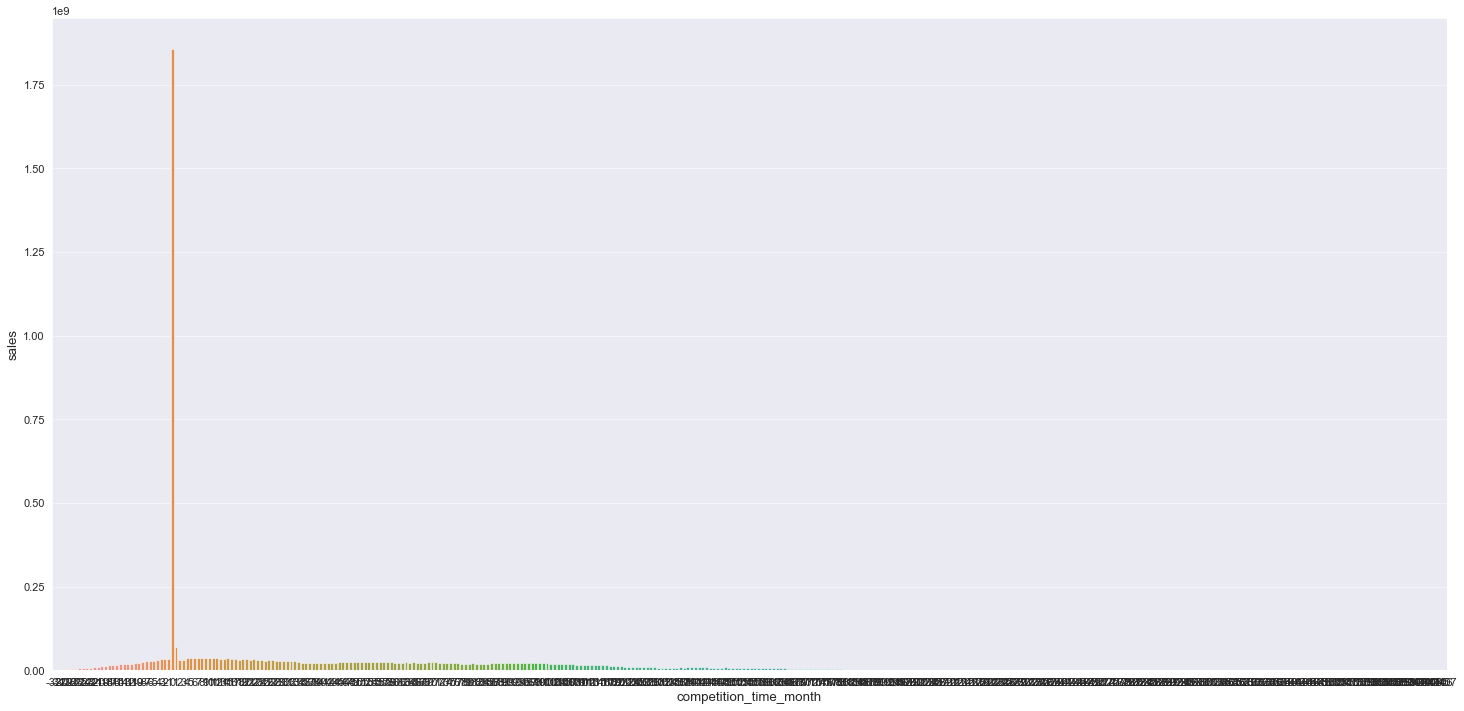

In [48]:
df_aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
df_aux2 = df_aux1[(df_aux1['competition_time_month'] < 120) & (df_aux1['competition_time_month'] != 0)]

sns.barplot( x = 'competition_time_month', y = 'sales', data = df_aux1);